In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from helpers import catmullrom3d
from helpers.utils import reorder_points
from helpers.descriptors import Section

In [2]:
# 1d gaussian kernel. 

def gaussiankern(l=5, sigma=1):
    """\
    creates 1d gaussian kernel with side length `l` and a sigma of `sig`
    """
    lags = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)

    gauss = np.exp(np.exp(-0.5 * np.square(lags) / np.square(sigma)))
    kernel = gauss / np.sum(gauss)
    return kernel

In [3]:
def smooth_gaussian(a, l, sigma):
    kernel = gaussiankern(l, sigma)
    half_width = int(l/2)
    b = np.zeros(len(a))
    for i in np.arange(0, len(a)):
        b[i] = kernel @ np.roll(a, -i)[0:l]

    return np.roll(b, half_width)


In [11]:
BASENAME = "09_GrotteDeVallorbe"
PASSAGE = "Toboggan"
SECTION = 1

# curvilinear coordinates
planes_origin = np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_z_interp_3d_Planes_Origin.txt")
curvilinear_pos = np.cumsum(np.linalg.norm(np.diff(planes_origin, axis = 0), axis = 1))
curvilinear_pos = np.pad(curvilinear_pos, (1, 0), "constant", constant_values = (0, 0))

In [19]:
# load a random section. 

section = np.loadtxt(f"../../real_data/{BASENAME}/process/sections_as_polylines/{PASSAGE}_{SECTION}_unordered_section_015.txt")

# reorder the points
reordered_section = reorder_points(section, 0)

s0 = Section(reordered_section, "None", 0, from3d=True)
s0.compute_descriptors()

# make a list of progressively smoothed sections.


<AxesSubplot:xlabel='X (m)', ylabel='Y (m)'>

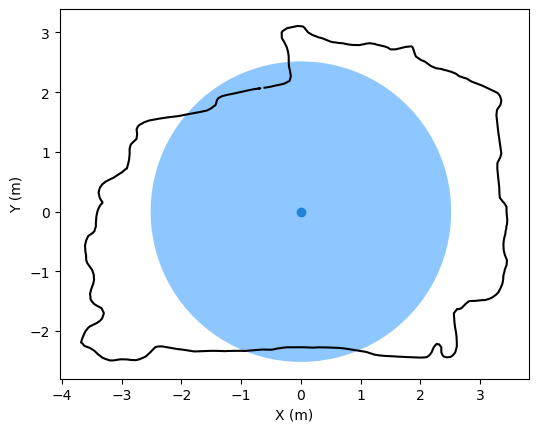

In [5]:
s0.plot_basic()

In [18]:
ordered = []
verbose = False
for curvilinear_idx in range(110):
    data = np.loadtxt(f"../../real_data/09_GrotteDeVallorbe/process/sections_as_polylines/Toboggan_1_unordered_section_{curvilinear_idx:03d}.txt")
    data = reorder_points(data.tolist(), 0)
    dists = np.linalg.norm(np.diff(data, axis = 0), axis = 1)
    id0 = 0
    idx = -1
    if np.any(dists > 0.2):
        if verbose == True:
            print("likely several segments")
        split = np.argwhere(dists > 0.2).flatten()
        split_data = np.array(np.split(data, split), dtype =object)
        ind = np.argmax(np.array([len(seg) for seg in split_data]))
    
        data = split_data[ind]

    # recentre to barycentre
    data = data - np.mean(data, axis = 0)
    # check if closed: 
    closure = np.linalg.norm(data[-1] - data[0])
    if closure > 0.2:
        print("there may be a closure error")
        s = Section(data, "ClosureError", curvilinear_pos[curvilinear_idx])
    else: 
        s = Section(data, "all ok", curvilinear_pos[curvilinear_idx])
    ordered.append(s)


there may be a closure error


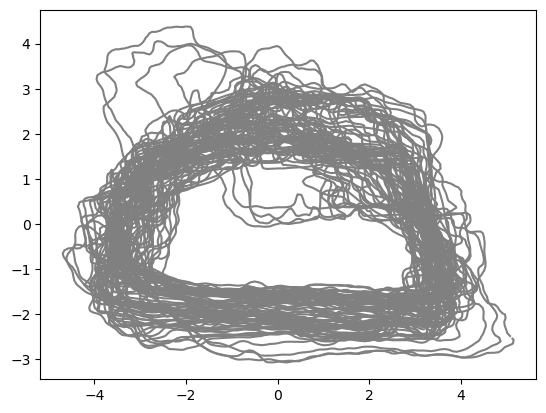

In [17]:
fig, ax = plt.subplots()

for s0 in ordered[10:]:

    s0.compute_descriptors()
    if s0.flag =="all ok":
        ax.plot(s0.points2d[:, 0], s0.points2d[:, 1], color = "grey")

plt.show()

In [6]:
dh = []
scaled_rh_dev = []
common_ratios = []

for i in range(95):
    
    section = np.loadtxt(f"../../real_data/09_GrotteDeVallorbe/process/sections_as_polylines/Toboggan_1_unordered_section_{i:03d}.txt")

    reordered_section = reorder_points(section, 0)
    s = Section(reordered_section, "None", 0, from3d=True)
    s.compute_descriptors()
    dh.append(s.hydraulic_diameter)
    scaled_rh_dev.append(s.mean_scaled_rh_deviation)
    common_ratios.append(s.common_ratio)

In [ ]:
#plt.plot(dh)
plt.scatter(scaled_rh_dev, common_ratios, marker = "+")


In [ ]:
L = 141
sigma = 70
points = reordered_section[:, [0,2]]

xi_smooth = smooth_gaussian(points[:,0], L, sigma)
yi_smooth = smooth_gaussian(points[:, 1], L, sigma)

smooth_points =  np.vstack((xi_smooth, yi_smooth)).T


In [ ]:
np.std(np.linalg.norm(points - smooth_points, axis = 1))

In [ ]:
s = Section(reordered_section, "None", 0, from3d=True)

In [ ]:
s.compute_descriptors()

In [ ]:
s.hydraulic_diameter

In [ ]:
s.print_basic_stats()

In [ ]:
thetai = np.linspace(-np.pi, np.pi, 100)

dh_circle = np.vstack([s.barycentre[0]+np.cos(thetai)*s.hydraulic_diameter/2, 
                s.barycentre[1]+np.sin(thetai)*s.hydraulic_diameter/2]).T

In [ ]:
fig, ax = plt.subplots()

ax.scatter(s.barycentre[0], s.barycentre[1])
ax.plot(s.points2d[:, 0], s.points2d[:, 1], zorder = 100, color = "k", label = "original")

ax.fill_between(s.barycentre[0]+ np.cos(thetai)*s.hydraulic_diameter/2, 
                s.barycentre[1]+np.sin(thetai)*s.hydraulic_diameter/2, 0, facecolor="dodgerblue", alpha = 0.5)

ax.set_aspect("equal")

std_dists = []
mean_dists = []
Li = [5, 11, 21, 41, 81, 161, 321, 641]
sigma_i = (np.array(Li) -1 ) 
for L, sigma in zip(Li, sigma_i):
    xi_smooth = smooth_gaussian(s.points2d[:,0], L, sigma)
    yi_smooth = smooth_gaussian(s.points2d[:, 1], L, sigma)

    smooth_points =  np.vstack((xi_smooth, yi_smooth)).T

    #print a measure of roughness. average distance between points and smooth? 

    dist = points - smooth_points 
    std_dist = np.std(np.linalg.norm(dist, axis = 1))
    mean_dist = np.mean(np.linalg.norm(dist, axis = 1))
    print(f"standard deviation of distances: {std_dist}")
    std_dists.append(std_dist)
    mean_dists.append(mean_dist)

    ax.plot(smooth_points[:, 0], smooth_points[:, 1], label=f"window size: {L}, sigma: {sigma}")

ax.scatter(s.points2d[0,0],s.points2d[0,1])
ax.scatter(dh_circle[79, 0], dh_circle[79, 1])
plt.show()

In [ ]:
plt.plot(np.linalg.norm(s.points2d - s.barycentre, axis =1) - s.hydraulic_diameter / 2)

In [ ]:
theta = np.arctan2(s.points2d[:,1] - s.barycentre[1], s.points2d[:,0] - s.barycentre[0])
rh_dev = np.linalg.norm(s.points2d - s.barycentre, axis =1) - s.hydraulic_diameter / 2

In [ ]:
s.perimeter / (np.pi * s.hydraulic_diameter )

In [ ]:
s.area / (np.pi * s.hydraulic_diameter**2 /4)

In [ ]:
plt.plot(theta)
plt.plot(rh_dev)

In [ ]:
# check closure: must be near 0.
np.sum(np.diff(theta)) + theta[0] - theta[-1]

In [ ]:
np.arctan2

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot()
ax.plot(points[:, 0], points[:, 1], zorder = 100, color = "k", label = "original")

std_dists = []
mean_dists = []
Li = [5, 11, 21, 41, 81, 161, 321, 641]
sigma_i = (np.array(Li) -1 ) /5
for L, sigma in zip(Li, sigma_i):
    xi_smooth = smooth_gaussian(points[:,0], L, sigma)
    yi_smooth = smooth_gaussian(points[:, 1], L, sigma)

    smooth_points =  np.vstack((xi_smooth, yi_smooth)).T

    #print a measure of roughness. average distance between points and smooth? 

    dist = points - smooth_points 
    std_dist = np.std(np.linalg.norm(dist, axis = 1))
    mean_dist = np.mean(np.linalg.norm(dist, axis = 1))
    print(f"standard deviation of distances: {std_dist}")
    std_dists.append(std_dist)
    mean_dists.append(mean_dist)

    ax.plot(smooth_points[:, 0], smooth_points[:, 1], label=f"window size: {L}, sigma: {sigma}")

ax.legend()
ax.set_xlim(-6, 4)
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_aspect("equal")
plt.savefig("Gaussian_Kernel_smooth.png", dpi = 300)

In [ ]:
mean_dists

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
ax1.loglog(Li, mean_dists, "o-")
ax1.set_xlabel("gaussian kernel window size")
ax1.set_ylabel("Mean distances to original curve")
ax2.loglog(Li, std_dists, "o-")
ax2.set_xlabel("gaussian kernel window size")
ax2.set_ylabel("SD of distances to original curve")
plt.tight_layout()
plt.savefig("GaussianKernel.png", dpi = 300)

In [ ]:
points1 = reordered_section1[:, [0,2]]


fig = plt.figure()
ax = fig.add_subplot()
ax.plot(points1[:, 0], points1[:, 1])

std_dists = []
Li = [5, 11, 21, 41, 81, 161, 321, 641, 1281]
for L, sigma in zip(Li, (2, 2, 2, 2, 2, 2, 2, 2, 2)):
    xi_smooth = smooth_gaussian(points1[:,0], L, sigma)
    yi_smooth = smooth_gaussian(points1[:, 1], L, sigma)

    smooth_points =  np.vstack((xi_smooth, yi_smooth)).T

    #print a measure of roughness. average distance between points and smooth? 

    dist = points1 - smooth_points 
    std_dist = np.std(np.linalg.norm(dist, axis = 1))
    print(f"standard deviation of distances: {std_dist}")
    std_dists.append(std_dist)
    ax.plot(smooth_points[:, 0], smooth_points[:, 1])


In [ ]:
plt.loglog(Li, std_dists, "o-")
plt.xlabel("gaussian kernel windows")
plt.ylabel("SD of distance to curve")

In [ ]:
NUM_POINTS = 40

# split by equal length segments. 
t = np.cumsum(np.linalg.norm(np.diff(smooth_points, axis =0), axis =1))

print(t)
split_indx = np.argwhere(t % 1 < t[-1] / (n+1))[:, 0]

# find the indices - here. 
sorted_split_indx =np.zeros(len(split_indx)+3, dtype=int)
sorted_split_indx[0:-3] = split_indx
sorted_split_indx[-3:] = sorted_split_indx[:3]

# make spline from segments 
split_chain_points: list = catmullrom3d.catmull_rom_chain(smooth_points[sorted_split_indx], NUM_POINTS, is3d=False)
assert len(split_chain_points) == catmullrom3d.num_segments(smooth_points[sorted_split_indx]) * NUM_POINTS  # 400 blue points for this example

print(sorted_split_indx)
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(points[:, 0], points[:, 1])
ax.plot(smooth_points[:, 0], smooth_points[:, 1], color = "C1")

ax.scatter(smooth_points[sorted_split_indx, 0], smooth_points[sorted_split_indx, 1])

ax.plot(*zip(*split_chain_points), c="red")
#ax.plot(5 * np.cos(ti), 5*np.sin(ti), c= "dodgerblue")
ax.set_aspect(aspect="equal")
plt.show()

In [ ]:
from helpers.descriptors import Section

In [ ]:
gkern_smooth_section = Section(smooth_points, "smooth", False)

In [ ]:
gkern_smooth_section.compute_descriptors()

In [ ]:
gkern_smooth_section.area

In [ ]:
rough_section = Section(points, "rough", False)
rough_section.compute_descriptors()

In [ ]:
rough_section.area

In [ ]:
np.pi * 25

In [ ]:
chain_points = np.vstack(split_chain_points)

In [ ]:
catmullrom_section = Section(chain_points, "rough", False)
catmullrom_section.compute_descriptors()

In [ ]:
catmullrom_section.area